In [1]:
import numpy as np
from scipy.optimize import minimize
from IPython.display import clear_output
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

rc = {"font.family" : "Times New Roman", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)

from QAOA import *
from hamiltonians import *
from heuristics import *
from visualization import *
from analysis import *

import warnings
warnings.filterwarnings("ignore")

### Generate a random instance of the Sherrington-Kirkpatrick model

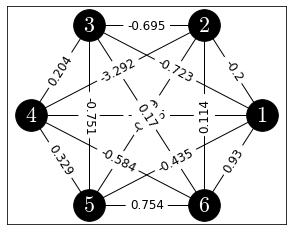

Ground state: -3.5078349395454635
Energy gap: 1.130093281613222
Max excited state energy: 2.972182794466305


In [2]:
# number of qubits
n = 6
n_edges = n*(n-1)//2

# ions chain parameters
nu_rad = 1e6
nu_ax = 0.15e6
mu = 2*np.pi*(nu_rad + 10e3) # in Hz
Omega_max = 2*np.pi*30e3     # in Hz

coupling_mat = radial_coupling_matrix(n, nu_rad, nu_ax, mu, Omega_max) # in kHz

# read data
index = 8 # data instance id from 1 to 100
# generate random Sherrington-Kirkpatrick instance
np.random.seed(100*index)
n_edges = n*(n-1)//2
weights = list(np.random.normal(size=n_edges))

G = get_weighted_graph(n,list(np.round(weights,3)))
pos = nx.circular_layout(G)

draw_graph(G, pos)

H2 = get_hamiltonian(n,weights)
gs = np.min(H2)
emax = np.max(H2)

spectrum = np.unique(np.sort(H2))

gap = spectrum[1] - spectrum[0]
print("Ground state:", gs)
print("Energy gap:", gap)
print("Max excited state energy:", emax)

### Train hyperparameters $A_j$

In [3]:
path = f'example_data/'
fname = f'{n}q_{index}.txt'
fname1 = path + fname

# read simulation parameters
n_iter = 30
max_restarts = 10
eps = 1e-3
tol_lvl = 0.5

np.random.seed(123*index)
training(path,fname,n,weights,coupling_mat,n_iter,tol_lvl,max_restarts,eps)

### Single-layered energy landscape

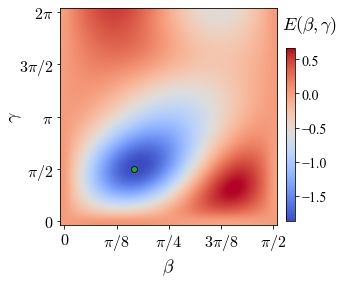

-1.8648824521740788 0.6596104900150657 [-0.323804 -0.628957 -0.224311 -1.       -0.209946  0.222954]


In [4]:
A = np.genfromtxt(fname1,skip_header=2)
H1 = ion_native_hamiltonian(n,A,coupling_mat)
Q = QAOA(1,H1,H2)
landscape = get_landscape(Q,k=25)
plot_landscape(landscape)
print(np.min(landscape),np.max(landscape),A)

### Rescale the hypeparameters to eliminate the narrow gorge

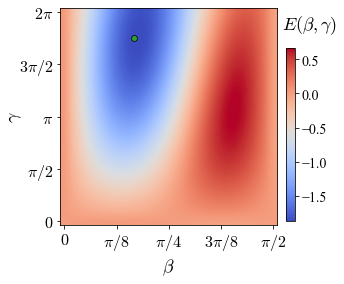

In [5]:
A_rescaled, alpha = rescale_contr_params(n,A,H2,coupling_mat,k=25,eps=0.05)
H1_rescaled = ion_native_hamiltonian(n,A_rescaled,coupling_mat)
Q = QAOA(1,H1_rescaled,H2)
landscape = get_landscape(Q,k=25)
plot_landscape(landscape)

### Single-layered energy for asymmetric $A_j$

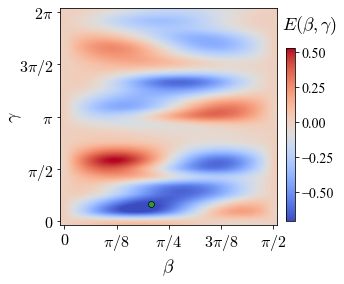

-0.7078091341366144


In [6]:
A_asym = np.ones(n)
A_asym[0] = -0.3
H1 = ion_native_hamiltonian(n,A_asym,coupling_mat)
Q = QAOA(1,H1,H2)
landscape = get_landscape(Q,k=25)
plot_landscape(landscape)
print(np.min(landscape))

### Evaluate the ion-native QAOA performance

#### Trained hyperparameters

In [7]:
p_max = 10
n_runs = 10

np.random.seed(12311)

H1 = ion_native_hamiltonian(n,A_rescaled,coupling_mat)
en, angles, ovlp = run_QAOA(H1,H2,p_max,n_runs)

pp = np.array(range(1,p_max+1))

data_trained = np.zeros((p_max,2))
data_trained[:,0] = pp
data_trained[:,1] = 1 - (en - emax)/(gs - emax)

#### Asymmetric hyperparameters

In [8]:
np.random.seed(12551)

H1 = ion_native_hamiltonian(n,A_asym,coupling_mat)
en1, angles1, ovlp1 = run_QAOA(H1,H2,p_max,n_runs)

data_asym = np.zeros((p_max,2))
data_asym[:,0] = pp
data_asym[:,1] = 1 - (en1 - emax)/(gs - emax)

### Plot fractional error

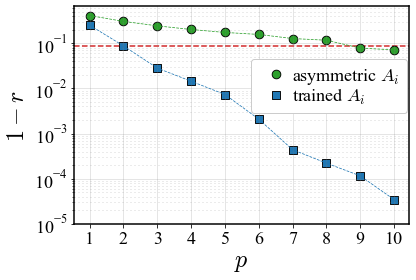

In [9]:
data_sets = [data_asym, data_trained]
labels = ['asymmetric $A_i$', 'trained $A_i$']
markers = ['o', 's']
colors = ['tab:green', 'tab:blue']

plot_energies_log(data_sets,labels,markers,colors,-gap/2.0/(gs - emax),1e-5)